In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
StpWd=set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import re
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay

In [4]:
df=pd.read_csv('/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv',sep='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df.shape

(3150, 5)

In [6]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [7]:
df=df.dropna()

In [8]:
df['length']=df['verified_reviews'].apply(len)

In [9]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [11]:
df['rating'].value_counts().reset_index()

,rating,count
0,5,2286
1,4,455
2,1,161
3,3,152
4,2,95


In [12]:
df_percent_rating=pd.DataFrame(df['rating'].value_counts().reset_index())
df_percent_rating.dtypes


rating    int64
count     int64
dtype: object

In [13]:
df_percent_rating['percent']=(df_percent_rating['count']*100/(df.shape[0]))

In [14]:
df_percent_rating

,rating,count,percent
0,5,2286,72.594474
1,4,455,14.449031
2,1,161,5.112734
3,3,152,4.826929
4,2,95,3.016831


In [15]:
df_percent_rating.groupby(df_percent_rating['rating']>2).sum()[['count','percent']]

,count,percent
rating,,
False,256,8.129565
True,2893,91.870435


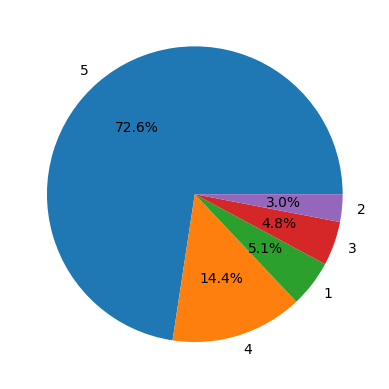

In [16]:
plt.pie(df_percent_rating['count'],labels=df_percent_rating['rating'],autopct='%1.1f%%')
plt.show()

In [17]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [18]:
df[(df['rating']==2)& (df['feedback']!=0)]

,rating,date,variation,verified_reviews,feedback,length



<div style="background-color: lightgray; padding: 10px; border-radius: 5px;">
    <p style="color: darkgreen;">feedback of '0' means 'negative review'
and
feedback of '1' means 'positive review'.</p>
    
</div>

In [19]:
df['variation'].value_counts().reset_index()

,variation,count
0,Black Dot,516
1,Charcoal Fabric,430
2,Configuration: Fire TV Stick,350
3,Black Plus,270
4,Black Show,265
5,Black,261
6,Black Spot,241
7,White Dot,184
8,Heather Gray Fabric,157
9,White Spot,109


<Axes: xlabel='variation'>

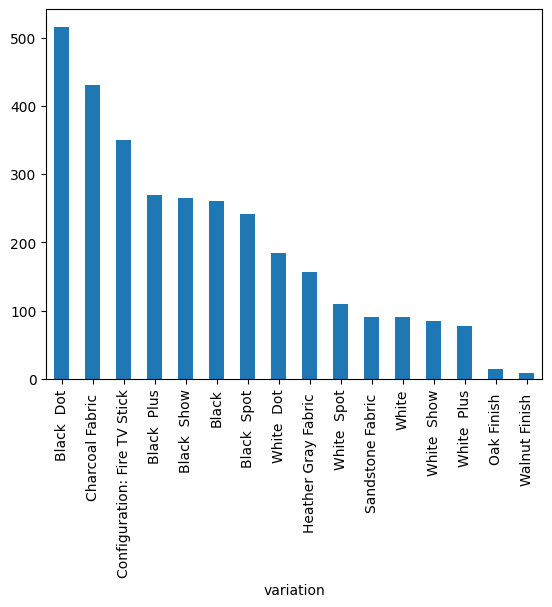

In [20]:
df['variation'].value_counts().plot.bar()

<Axes: xlabel='variation'>

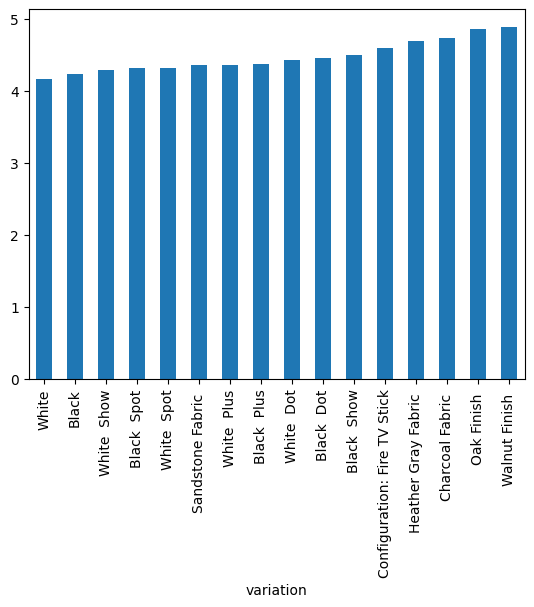

In [21]:
df.groupby('variation')['rating'].mean().sort_values().plot.bar()

In [22]:
df['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

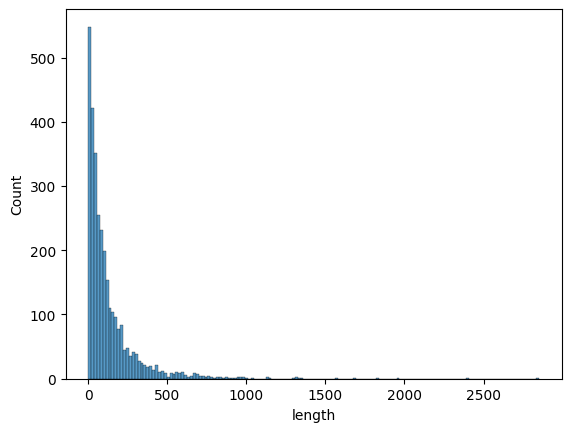

In [23]:
sns.histplot(df['length'])
plt.plot()

<Axes: xlabel='rating'>

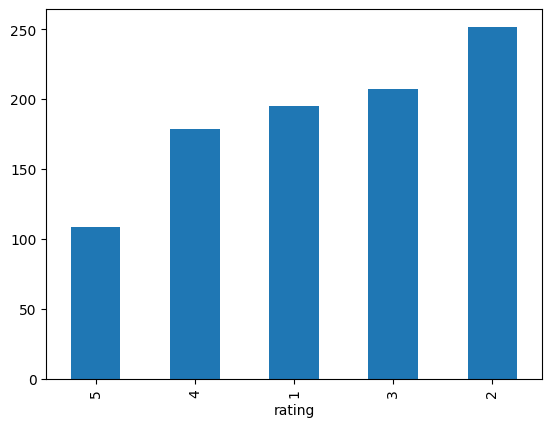

In [24]:
df.groupby('rating')['length'].mean().sort_values().plot.bar()

In [25]:
vectorizer=CountVectorizer(stop_words='english')


In [26]:
words=vectorizer.fit_transform(df['verified_reviews'])

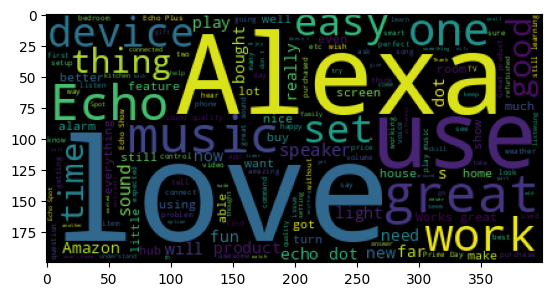

In [27]:
# for all reviews
reviews=' '.join(review for review in df['verified_reviews'])
wc=WordCloud()
plt.imshow(wc.generate(reviews))
plt.show()

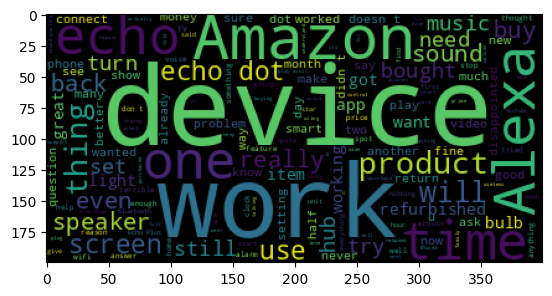

In [28]:
# for -ve reviews
reviews=' '.join(review for review in df[df['feedback']!=1]['verified_reviews'])
wc=WordCloud()
plt.imshow(wc.generate(reviews))
plt.show()

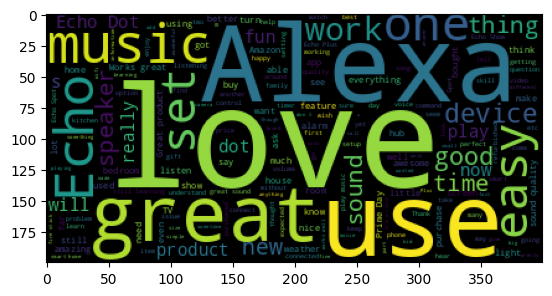

In [29]:
# for +ve reviews
reviews=' '.join(review for review in df[df['feedback']==1]['verified_reviews'])
wc=WordCloud()
plt.imshow(wc.generate(reviews))
plt.show()

# MODELLING

In [30]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [31]:
corpus=[]
stemmer=PorterStemmer()
for i in range(0,df.shape[0]):
    reviews=re.sub('[^a-zA-Z]',' ',df.iloc[i]['verified_reviews'])
    reviews.lower().split()
    reviews=[stemmer.stem(word)for word in reviews if not word in StpWd]
    reviews=''.join(reviews)
    corpus.append(reviews)

In [32]:
# corpus

In [33]:
cv=CountVectorizer(max_features=2500)
X=cv.fit_transform(corpus).toarray()

In [34]:
y=df['feedback'].values

In [35]:
pickle.dump(cv,open('countervectorizer.pkl','wb'))

In [36]:
X.shape

(3149, 2500)

In [37]:
y.shape

(3149,)

In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3)

In [39]:
print(f"X train :{X_train.shape}")
print(f"X test :{X_test.shape}")
print(f"y train :{y_train.shape}")
print(f"y test :{y_test.shape}")

X train :(2204, 2500)
X test :(945, 2500)
y train :(2204,)
y test :(945,)


In [40]:

scaler=MinMaxScaler()

In [41]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [42]:
pickle.dump(scaler,open('scaler.pkl','wb'))

In [43]:
classifier=RandomForestClassifier()

In [44]:
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [45]:
pred=classifier.predict(X_test)

In [46]:
classifier.score(X_train,y_train)

0.9945553539019963

In [47]:
classifier.score(X_test,y_test)

0.9343915343915344

In [48]:
accuracy_score(y_test,pred)

0.9343915343915344

In [49]:
cm=confusion_matrix(y_test,pred)

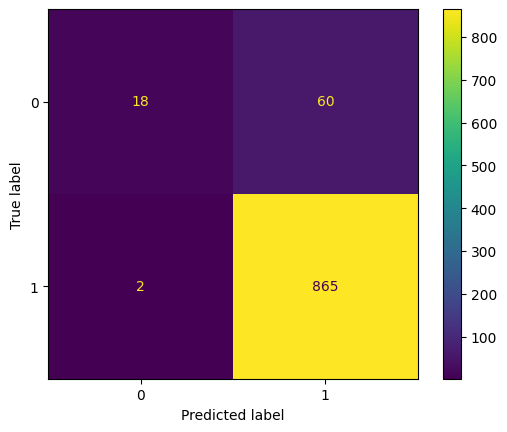

In [50]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [51]:
accuracies=cross_val_score(estimator=classifier,X=X_train,y=y_train,cv=10)
accuracies.mean()

0.9373940765117235

In [52]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [53]:
cv_object = StratifiedKFold(n_splits = 2)
grid_search = GridSearchCV(estimator = classifier, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [54]:
print('best params :',grid_search.best_params_)

best params : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 300}


In [55]:
model=RandomForestClassifier(bootstrap=True,max_depth=100,min_samples_split=12,n_estimators=100)

In [56]:
grid_search.cv_results_

{'mean_fit_time': array([0.71453738, 2.06285584, 0.70048225, 2.04536772, 0.70640647,
        2.11446738, 0.70921981, 2.07510972]),
 'std_fit_time': array([0.02032757, 0.01958001, 0.00344837, 0.01046133, 0.01193893,
        0.03857851, 0.00344718, 0.0173347 ]),
 'mean_score_time': array([0.03830421, 0.09843612, 0.03520346, 0.09741211, 0.03728807,
        0.10221231, 0.03551757, 0.10060823]),
 'std_score_time': array([0.00414407, 0.00102973, 0.00059128, 0.00315166, 0.00037014,
        0.00105894, 0.00013411, 0.00215256]),
 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[80, 80, 80, 80, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[8, 8,

In [57]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, pred))

Cross validation mean accuracy on train set : 96.50635208711434
Cross validation mean accuracy on test set : 92.20167876588022
Accuracy score for test set : 0.9343915343915344
